In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(1003)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

# Taking a glance at the data
players
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [4]:
set.seed(1003)
session_summary <- sessions |>
    mutate(session_length = (original_end_time - original_start_time) / (1000 * 60)) |>
    group_by(hashedEmail) |>
    summarize(
        n_sessions = n(),
        mean_session_length = mean(session_length, na.rm = TRUE))

# Joining the datasets and removing N/As
full_data <- players |>
    left_join(session_summary, by = 'hashedEmail') |>
    filter(!is.na(played_hours) , !is.na(experience) , !is.na(n_sessions))

full_data

experience,subscribe,hashedEmail,played_hours,name,gender,Age,n_sessions,mean_session_length
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27,74.07407
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3,55.55556
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1,0.00000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,1,0
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,6,0
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA,1,0


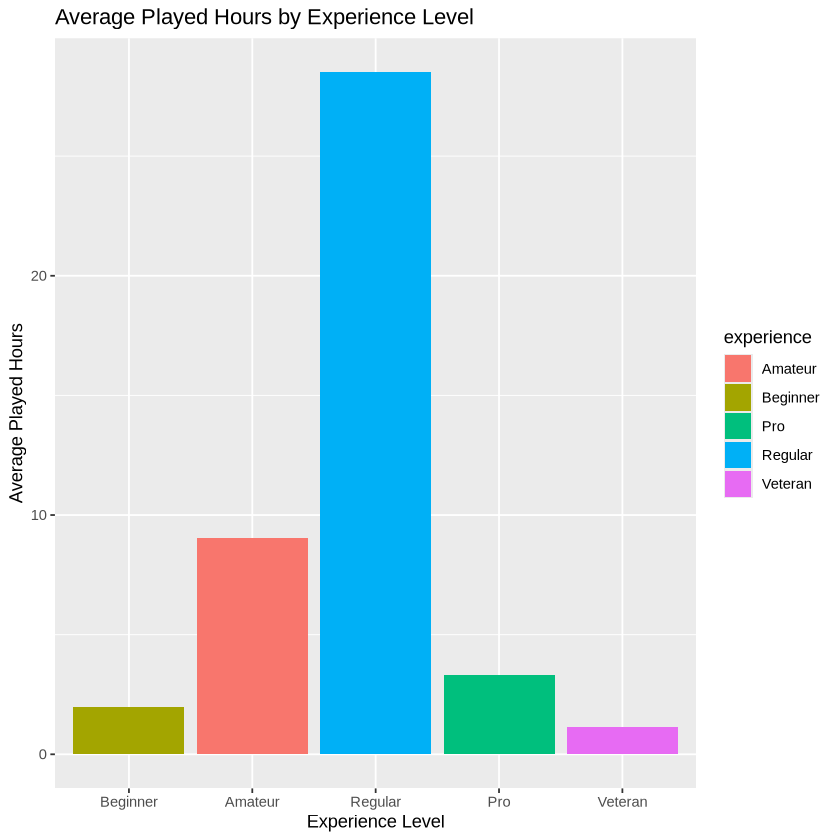

In [5]:
experience_summary <- full_data |>
    group_by(experience) |>
    summarize(mean_hours = mean(played_hours, na.rm = TRUE))

experience_summary |>
    ggplot(aes(x = fct_relevel(experience, 'Beginner', 'Amateur', 'Regular', 'Pro', 'Veteran'), y = mean_hours, fill = experience)) +
    geom_col() +
    labs(title = 'Average Played Hours by Experience Level', x = 'Experience Level', y = 'Average Played Hours')

In [6]:
set.seed(1003)
split <- initial_split(full_data, prop = 0.7)
train <- training(split)
test <- testing(split)

recipe_obj <- recipe(played_hours ~ n_sessions + mean_session_length + experience, data = train)

model_spec <- linear_reg() |>
  set_engine('lm')

workflow_obj <- workflow() |>
  add_recipe(recipe_obj) |>
  add_model(model_spec)

fit_model <- fit(workflow_obj, data = train)

# Evaluating the model
lm_rmse <- fit_model |> 
    predict(train)|>
    bind_cols(train)|>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == 'rmse')
lm_rmse  

lm_rmspe <- fit_model |> 
    predict(test) |>
    bind_cols(test) |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == 'rmse')
lm_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,16.08473


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,37.93906


In [7]:
#TESTING KNN REGRESSION
set.seed(1003)
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')
recipe_scaled <- recipe(played_hours ~ n_sessions + mean_session_length + experience, data = train) |>
    step_scale(all_numeric_predictors())|>
    step_center(all_numeric_predictors())
gridvals <- tibble(neighbors = seq(from = 1, to = 62, by = 3))
player_vfold <- vfold_cv(train, v = 5, strata = played_hours)

player_wkflw <- workflow() |>
    add_recipe(recipe_scaled) |>
    add_model(knn_spec)

player_results <- player_wkflw |>
    tune_grid(resamples = player_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == 'rmse')

player_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,19.57383,5,7.209265,Preprocessor1_Model01
4,rmse,standard,14.99930,5,9.454356,Preprocessor1_Model02
7,rmse,standard,18.42612,5,10.486167,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,rmse,standard,25.22798,5,12.44011,Preprocessor1_Model19
58,rmse,standard,25.29759,5,12.46209,Preprocessor1_Model20
61,rmse,standard,25.35302,5,12.48701,Preprocessor1_Model21


In [8]:
#Finding min k
player_min <- player_results |> filter(mean == min(mean))
kmin <- player_min |> pull(neighbors)
kmin

[1] 4

In [9]:
set.seed(1003)
player_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = kmin) |>
  set_engine('kknn') |>
  set_mode('regression')

player_wk <- workflow() |>
    add_recipe(recipe_obj) |>
    add_model(player_spec) |> 
    fit(data = train)

player_summary <- player_wk |>
  predict(test) |>
  bind_cols(test) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

player_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,11.98774
